In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvas
from scipy.spatial import distance
import random
import pickle
from scipy import stats
import time


# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

import max_ent.examples.grid_9_by_9 as G
from max_ent.utility.support import *
from max_ent.gridworld import Directions


random.seed(123)
np.random.seed(123)

In [2]:
n_trials = 1 #

n_trajectories = 10

bootstrap = 0

threshold1 = 200 # {10, 50, 100, 200, 300} default 200
threshold2 = 0.5 # {0, 0.2, 0.4, 0.6, 0.8, 1} default 0.5
threshold3 = 0.5 # {0, 0.2, 0.4, 0.6, 0.8, 1} default 0.5
threshold4 = 0 # {0, 0.2, 0.4, 0.6, 0.8, 1} default 0.5
threshold5 = 0 # means default w=[1,0]
threshold7 = 0.9 # {0, 0.2, 0.4, 0.6, 0.8, 1} default 0.5

df = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()
df4 = pd.DataFrame()
df7 = pd.DataFrame()

In [3]:
def compute_mean(target = None):
    
    usage_s1 = []
    usage_s2 = []
    time_s2 = []
    time_s1 = []

    avg_time_s2 = []
    avg_time_s1 = []

    df = pd.DataFrame()

    if target: 

        for i in range(0, len(target.time_stat)):
            #print(f"Stat: {mca.trajectory_stat[i]}")
            mask_1 = np.array(target.trajectory_stat[i]) == 1
            mask_2 = np.array(target.trajectory_stat[i]) == 0
            #print(f"Mask: {mask}")
            selected = np.array(target.time_stat[i])
            #print(f"Selected before: {selected}")
            selected_1= selected[mask_1]
            selected_2= selected[mask_2]
            #print(f"Selected after: {selected}")
            time_s1.append(np.sum(selected_1))    
            time_s2.append(np.sum(selected_2))
            avg_time_s1.append(np.mean(selected_1))    
            avg_time_s2.append(np.mean(selected_2))
            usage_s1.append(np.sum(target.trajectory_stat[i])/(len(target.trajectory_stat[i])))    
            usage_s2.append((len(target.trajectory_stat[i])-np.sum(target.trajectory_stat[i]))/(len(target.trajectory_stat[i])))

            dict_mca = {}
            dict_mca['traj_n'] = i
            dict_mca['time_s1'] = np.sum(selected_1)
            dict_mca['time_s2'] = np.sum(selected_2)
            dict_mca['avg_time_s1'] = np.mean(selected_1)
            dict_mca['avg_time_s2'] = np.mean(selected_2)
            dict_mca['usage_s1']= np.sum(target.trajectory_stat[i])/(len(target.trajectory_stat[i]))
            dict_mca['usage_s2']= (len(target.trajectory_stat[i])-np.sum(target.trajectory_stat[i]))/(len(target.trajectory_stat[i]))
            temp_df = pd.DataFrame(data=dict_mca, index=[i])
            df = pd.concat([df, temp_df])
            
    else:
        dict_mca = {}
        dict_mca['traj_n'] = 0
        dict_mca['time_s1'] = 0
        dict_mca['time_s2'] = 0
        dict_mca['avg_time_s1'] = 0
        dict_mca['avg_time_s2'] = 0
        dict_mca['usage_s1']= 0
        dict_mca['usage_s2']= 0
        temp_df = pd.DataFrame(data=dict_mca, index=[0])
        df = pd.concat([df, temp_df])

    
    #print(dict_mca)
    
    return df


In [4]:
def plot_results(df, x, y, min_label, max_label):
    
    #print(df)

    print(f"RL\t -> Length: {np.mean(df.loc[(df['type']=='const')]['Length'].values):8.4f} \t Rew: {np.mean(df.loc[(df['type']=='const')]['Reward'].values):10.4f} \t Viol.: {np.mean(df.loc[(df['type']=='const')]['Viol'].values)}")    
    print(f"MCA 10\t -> Length: {np.mean(df.loc[(df['type']=='10') & (df['t1']==200)]['Length'].values):8.4f} \t Rew: {np.mean(df.loc[(df['type']=='10') & (df['t1']==200)]['Reward'].values):10.4f} \t Viol.: {np.mean(df.loc[(df['type']=='10') & (df['t1']==200)]['Viol'].values)}")
    print(f"MCA 01\t -> Length: {np.mean(df.loc[(df['type']=='01') & (df['t1']==200)]['Length'].values):8.4f} \t Rew: {np.mean(df.loc[(df['type']=='01') & (df['t1']==200)]['Reward'].values):10.4f} \t Viol.: {np.mean(df.loc[(df['type']=='01') & (df['t1']==200)]['Viol'].values)}")
    print(f"MCA 55\t -> Length: {np.mean(df.loc[(df['type']=='02') & (df['t1']==200)]['Length'].values):8.4f} \t Rew: {np.mean(df.loc[(df['type']=='02') & (df['t1']==200)]['Reward'].values):10.4f} \t Viol.: {np.mean(df.loc[(df['type']=='02') & (df['t1']==200)]['Viol'].values)}")
    print(f"Only S1\t -> Length: {np.mean(df.loc[(df['type']=='s1')]['Length'].values):8.4f} \t Rew: {np.mean(df.loc[(df['type']=='s1')]['Reward'].values):10.4f} \t Viol.: {np.mean(df.loc[(df['type']=='s1')]['Viol'].values)}")
    print(f"Only S2\t -> Length: {np.mean(df.loc[(df['type']=='s2')]['Length'].values):8.4f} \t Rew: {np.mean(df.loc[(df['type']=='s2')]['Reward'].values):10.4f} \t Viol.: {np.mean(df.loc[(df['type']=='s2')]['Viol'].values)}")
    
    fig=plt.figure(figsize=(12, 7))
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_theme(style="whitegrid")
    sns.set(font_scale=2)
    sns.color_palette("viridis", as_cmap=True)
    #g=sns.lineplot(x=x, y=y, data=df, hue="type",markers=True, dashes=False)
    g = sns.barplot(x=x, y=y, hue="type", data=df.loc[(df['type']!="const")& (df['type']!="s1") & (df['type']!="s2")], palette="autumn", ci=95);
    #g.set_xticklabels([f"({(i)/10:0.1f}, {1 - (i)/10:0.1f})" for i in range(11)])
    
    constrained_line = np.median(df.loc[(df['type']=="const")][y])
    s1_line = np.median(df.loc[(df['type']=="s1")][y])
    s2_line = np.median(df.loc[(df['type']=="s2")][y])
    
    g.axhline(constrained_line, color='r', linestyle='--', label="RL")
    g.axhline(s1_line, color='b', linestyle='--', label="S1")

    g.axhline(s2_line, color='g', linestyle='-.', label="S2")
    g.set_ylim([min_label, max_label])

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(label=y+" varying "+x)
    
    plt.legend()
    plt.grid(alpha=0.3)
    #g.set_xticks(range(11)) # <--- set the ticks first

    #plt.xlabel("W(Nominal, Constraints)")
    #plt.ylabel("Avg JS dist")
    plt.show()
    #fig.savefig(os.path.join("./", f"{y}_varying_{x}.png"), bbox_inches = 'tight')

In [5]:
from mc.self import *
from mc.system1 import *
from mc.system2 import *
from mc.mca import *

def build_dict(temp_matrix, type_mca, agent=None, s1_usage=0,  t1=0, t2=0, t3=0, t4=0, t6=0, t7=0):
    '''temp_dict={}
    temp_dict['type']= type_mca
    temp_dict['Length']= temp_matrix[1]
    temp_dict['Reward']= temp_matrix[2]
    temp_dict['Viol'] = temp_matrix[4]
    temp_dict['S1_Usage'] = s1_usage
    temp_dict['t1'] = t1
    temp_dict['t2'] = t2
    temp_dict['t3'] = t3
    temp_dict['t4'] = t4
    temp_dict['t6'] = t6
    temp_dict['t7'] = t7
    temp_df = pd.DataFrame(data=temp_dict, index=[0])'''
    
    temp_df = compute_mean(agent)
    temp_df['type']= type_mca
    temp_df['Length']= temp_matrix[1]
    temp_df['Reward']= temp_matrix[2]
    temp_df['Viol'] = temp_matrix[4]
    temp_df['S1_Usage'] = s1_usage
    temp_df['t1'] = t1
    temp_df['t2'] = t2
    temp_df['t3'] = t3
    temp_df['t4'] = t4
    temp_df['t6'] = t6
    temp_df['t7'] = t7
    
    return temp_df
    

def simulation(n_cfg, c_cfg, demo, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories=200, 
               threshold1 = [200], threshold2 = [0.5], threshold3 = [0.5], 
               threshold4 = [0.5], threshold6 = [1], threshold7 = [0.5], df=None, bootstrap = 0):
    
    if df is None:
        df = pd.DataFrame()
   
    n=n_cfg.mdp
    c=c_cfg.mdp
    
    temp_matrix = count_states(demo.trajectories, c_cfg.mdp, n, constraints)
    temp_dict=build_dict(temp_matrix, type_mca='const')
    df = pd.concat([df, temp_dict])

    #mca_s1 = MCA(n=n, c=c, demo=demo, only_s1=True)
    #demo_mca_s1 = mca_s1.generate_trajectories(n_trajectories)
    temp_matrix_mca_s1 = count_states(demo_mca_s1.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
    temp_dict=build_dict(temp_matrix_mca_s1, type_mca='s1', agent=mca_s1, s1_usage=mca_s1.getStatistics()[0])
    df = pd.concat([df, temp_dict])

    #mca_s2 = MCA(n=n, c=c, demo=demo, only_s2=True)
    #demo_mca_s2 = mca_s2.generate_trajectories(n_trajectories)
    temp_matrix_mca_s2 = count_states(demo_mca_s2.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
    temp_dict=build_dict(temp_matrix_mca_s2, type_mca='s2', agent=mca_s2 )
    df = pd.concat([df, temp_dict])
    
    for t1 in threshold1:
        for t2 in threshold2:
            for t3 in threshold3:
                for t4 in threshold4:
                    for t6 in threshold6:
                        for t7 in threshold7:
                            mca_10 = MCA(n=n, c=c, demo=None, threshold1=t1, threshold2=t2, threshold3 = t3, threshold4 = t4, threshold5 = 0, threshold6 = t6, threshold7 = t7)
                            demo_mca_10 = mca_10.generate_trajectories(n_trajectories)
                            temp_matrix_mca_10 = count_states(demo_mca_10.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
                            temp_dict=build_dict(temp_matrix_mca_10, type_mca='10', agent= mca_10, s1_usage=mca_10.getStatistics()[0], t1=t1, t2=t2, t3=t3, t4=t4, t6=t6, t7=t7)
                            df = pd.concat([df, temp_dict])


                            mca_01 = MCA(n=n, c=c, demo=None, threshold1=t1, threshold2=t2, threshold3 = t3, threshold4 = t4, threshold5 = 1, threshold6 = t6, threshold7 = t7)
                            demo_mca_01 = mca_01.generate_trajectories(n_trajectories)
                            temp_matrix_mca_01 = count_states(demo_mca_01.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
                            temp_dict=build_dict(temp_matrix_mca_01, type_mca='01', agent=mca_01, s1_usage=mca_01.getStatistics()[0], t1=t1, t2=t2, t3=t3, t4=t4, t6=t6, t7=t7)
                            df = pd.concat([df, temp_dict])
                            

                            mca_02 = MCA(n=n, c=c, demo=None, threshold1=t1, threshold2=t2, threshold3 = t3, threshold4 = t4, threshold5 = 2, threshold6 = t6, threshold7 = t7)
                            demo_mca_02 = mca_02.generate_trajectories(n_trajectories)
                            temp_matrix_mca_02 = count_states(demo_mca_02.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
                            temp_dict=build_dict(temp_matrix_mca_02, type_mca='02', agent=mca_02, s1_usage=mca_02.getStatistics()[0], t1=t1, t2=t2, t3=t3, t4=t4, t6=t6, t7=t7)
                            df = pd.concat([df, temp_dict])
                            f1 = G.plot_world(f'MCA 02', c, c_cfg.state_penalties, c_cfg.action_penalties, c_cfg.color_penalties, demo_mca_02, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
                                                         
                            
    return df

In [6]:
## Set the grid
'''blue = [21,  9, 59,  1,  0, 20]
green = [42, 18, 76, 41, 23, 30]
cs = [63, 74, 13, 39, 48, 38]
ca = [Directions.DOWN_LEFT, Directions.UP_LEFT]
start =7
goal = 65

constraints = {'blue': blue, 'green': green, 'cs':cs, 'ca':ca}'''

"blue = [21,  9, 59,  1,  0, 20]\ngreen = [42, 18, 76, 41, 23, 30]\ncs = [63, 74, 13, 39, 48, 38]\nca = [Directions.DOWN_LEFT, Directions.UP_LEFT]\nstart =7\ngoal = 65\n\nconstraints = {'blue': blue, 'green': green, 'cs':cs, 'ca':ca}"

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10f30b470>}
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10f30b470>}


/Users/aloreggia/Documents/GitHub/wmca/mc/self.py:237: RuntimeWarning: invalid value encountered in double_scalars
  return self.part_reward[state_s_coord] / self.getNTrajectories(state_s)
/Users/aloreggia/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aloreggia/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aloreggia/Documents/GitHub/wmca/mc/mca.py:178: RuntimeWarning: invalid value encountered in double_scalars
  x = np.abs(current_length - expected_avg_length) / max_diff_len


{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10f30b470>}
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10f30b470>}
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10f30b470>}
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10f30b470>}
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10f30b470>}
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10f30b470>}
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10f30b470>}
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10f30b470>}
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10f30b470>}
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10

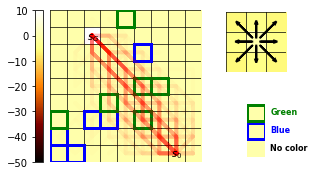

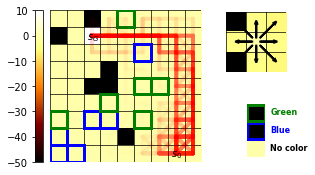

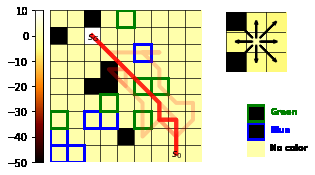

In [7]:
time_tot = int(round(time.time() * 1000))

for i in range(n_trials):
    #generate constraints
    #blue, green, cs, ca, start, goal = generate_constraints(9)
    #constraints = {'blue': blue, 'green': green, 'cs':cs, 'ca':ca}
    
    blue = [21,  9, 59,  1,  0, 20]
    green = [42, 18, 76, 41, 23, 30]
    cs = [63, 74, 13, 39, 48, 38]
    ca = [Directions.DOWN_LEFT, Directions.UP_LEFT]
    start =7
    goal = 65

    constraints = {'blue': blue, 'green': green, 'cs':cs, 'ca':ca}
    
    #generate nomminal 
    n, n_cfg, demo_n, f1 = create_world('Nominal', blue, green, start=start, goal=goal)
    
    #generate constrained grid
    cc = [1, 2]
    c, c_cfg, demo_c, f2 = create_world('Constrained', blue, green, cs, ca, cc, start=start, goal=goal, check=True)
    
    mca_s1 = MCA(n=n, c=c, demo=demo_c, only_s1=True)
    demo_mca_s1 = mca_s1.generate_trajectories(n_trajectories)
    
    mca_s2 = MCA(n=n, c=c, demo=demo_c, threshold5=2, only_s2=True)
    demo_mca_s2 = mca_s2.generate_trajectories(n_trajectories)
    
    time_exp = int(round(time.time() * 1000))
    df = simulation(n_cfg, c_cfg, demo_c, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories, threshold1 = [10, 50, 100, 200, 300], df=df, bootstrap = bootstrap)
    time_exp = int(round(time.time() * 1000)) - time_exp

    df2 = simulation(n_cfg, c_cfg, demo_c, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories, threshold2 = [0, 0.2, 0.4, 0.6, 0.8, 1], df = df2, bootstrap = bootstrap)
    df3 = simulation(n_cfg, c_cfg, demo_c, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories, threshold3 = [0, 0.2, 0.4, 0.6, 0.8, 1], df = df3, bootstrap = bootstrap)
    df4 = simulation(n_cfg, c_cfg, demo_c, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories, threshold4 = [0, 0.2, 0.4, 0.6, 0.8, 1], df = df4, bootstrap = bootstrap)
    df7 = simulation(n_cfg, c_cfg, demo_c, demo_mca_s1, demo_mca_s2, mca_s1, mca_s2, constraints, n_trajectories, threshold7 = [0, 0.2, 0.4, 0.6, 0.8, 1], df = df7, bootstrap = bootstrap)

    print(f"Varying t1: {time_exp}")

time_tot = int(round(time.time() * 1000)) - time_tot
print(f"Total time: {time_tot}")


In [8]:
label='Length'
list_df = [df[label],df2[label],df3[label],df4[label],df7[label]]
list_mean=[(np.mean(x)+np.std(x))*1.1 for x in list_df]

print(np.max(list_mean))

def min_max(label, df, df2, df3, df4, df7):
    list_df = [df[label],df2[label],df3[label],df4[label],df7[label]]
    list_mean=[(np.mean(x) + np.sign(np.mean(x)) * np.std(x))*1.1 for x in list_df]
    print(list_mean)
    min_label=np.min(list_mean)
    max_label=np.max(list_mean)
    
    if min_label < 0 and max_label < 0:
        max_label = 0
    elif min_label > 0 and max_label > 0:
        min_label = 0
    
    return min_label, max_label

96.30558993810897


[42.621926688511145, 53.3776329737806, 38.167933684908, 41.32305575228073, 96.30558993810897]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  12.6000 	 Rew:  -316.3196 	 Viol.: 5.799999999999999
MCA 01	 -> Length:  36.6000 	 Rew:  -392.2205 	 Viol.: 5.200000000000001
MCA 55	 -> Length:  12.1000 	 Rew:  -305.5941 	 Viol.: 5.700000000000001
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


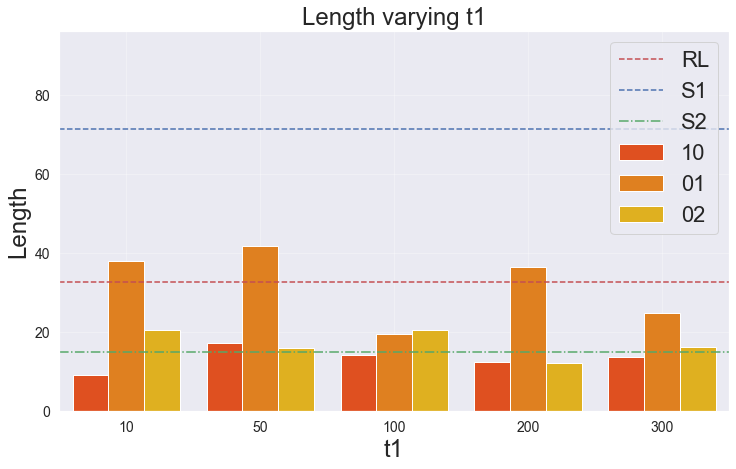

[-493.7022596866881, -580.0741490373201, -669.3357197192875, -613.62720506348, -2061.994014564892]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  12.6000 	 Rew:  -316.3196 	 Viol.: 5.799999999999999
MCA 01	 -> Length:  36.6000 	 Rew:  -392.2205 	 Viol.: 5.200000000000001
MCA 55	 -> Length:  12.1000 	 Rew:  -305.5941 	 Viol.: 5.700000000000001
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


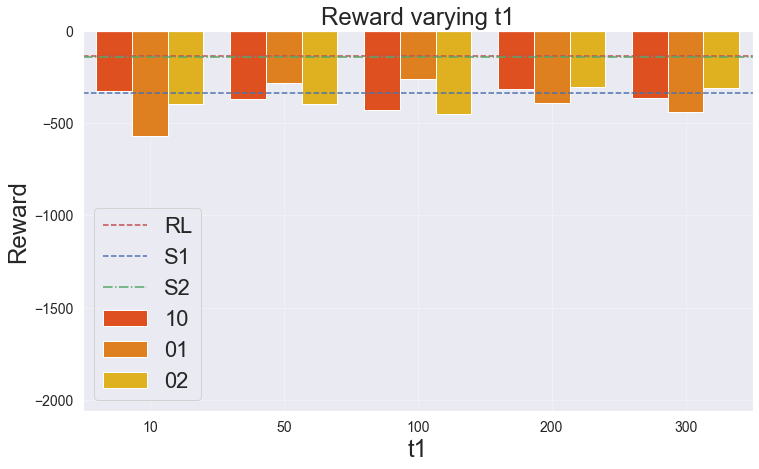

[8.651169023820456, 9.556737518473017, 12.058541155488301, 10.917812478919263, 34.99791417781053]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  12.6000 	 Rew:  -316.3196 	 Viol.: 5.799999999999999
MCA 01	 -> Length:  36.6000 	 Rew:  -392.2205 	 Viol.: 5.200000000000001
MCA 55	 -> Length:  12.1000 	 Rew:  -305.5941 	 Viol.: 5.700000000000001
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


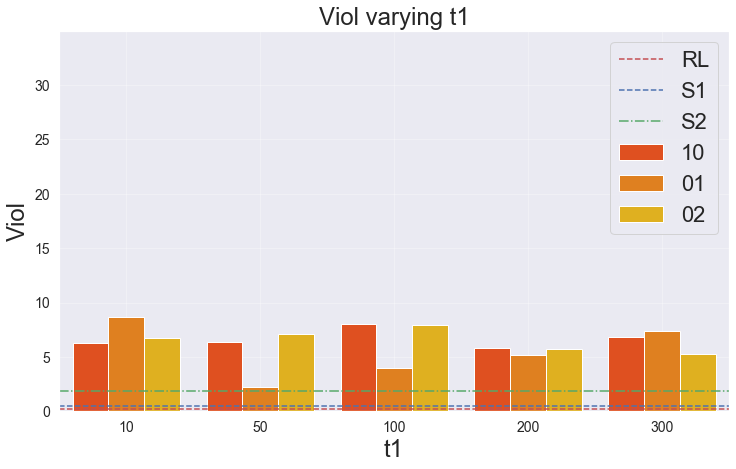

[1.020723234928426, 1.039667900949046, 1.0067693680959025, 0.973504865928162, 1.1214340261963607]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  12.6000 	 Rew:  -316.3196 	 Viol.: 5.799999999999999
MCA 01	 -> Length:  36.6000 	 Rew:  -392.2205 	 Viol.: 5.200000000000001
MCA 55	 -> Length:  12.1000 	 Rew:  -305.5941 	 Viol.: 5.700000000000001
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


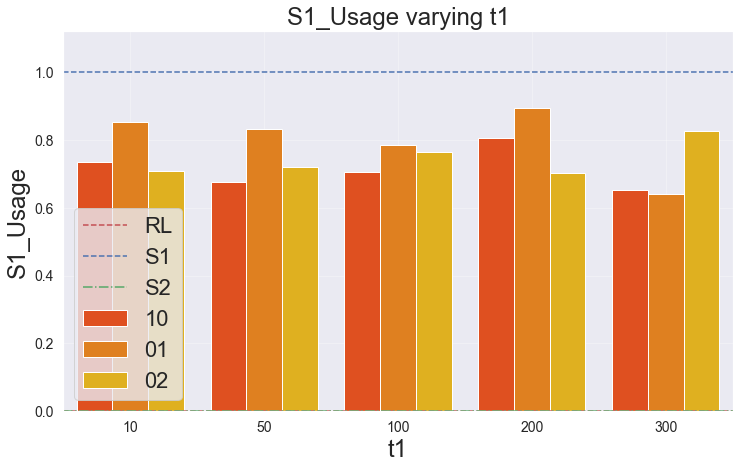

In [9]:
label_x = 't1'
label='Length'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='Reward'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='Viol'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='S1_Usage'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df,x=label_x,y=label, min_label=min_label, max_label=max_label)

[42.621926688511145, 53.3776329737806, 38.167933684908, 41.32305575228073, 96.30558993810897]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  15.5167 	 Rew:  -387.4869 	 Viol.: 6.999999999999998
MCA 01	 -> Length:  38.9500 	 Rew:  -331.0437 	 Viol.: 3.683333333333333
MCA 55	 -> Length:  19.1833 	 Rew:  -463.4124 	 Viol.: 8.2
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


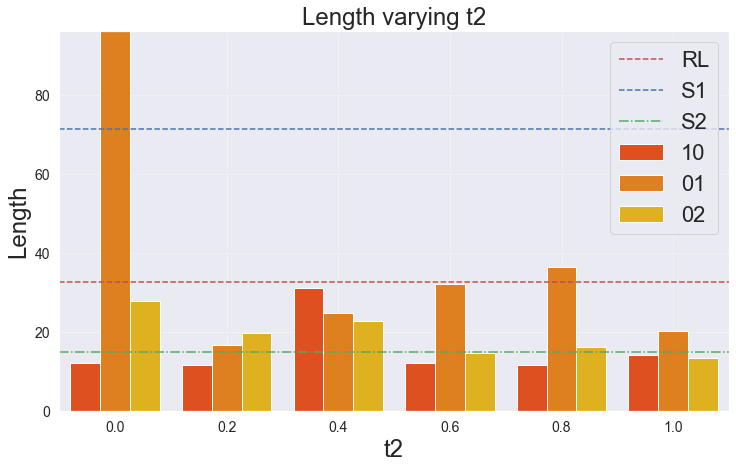

[-493.7022596866881, -580.0741490373201, -669.3357197192875, -613.62720506348, -2061.994014564892]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  15.5167 	 Rew:  -387.4869 	 Viol.: 6.999999999999998
MCA 01	 -> Length:  38.9500 	 Rew:  -331.0437 	 Viol.: 3.683333333333333
MCA 55	 -> Length:  19.1833 	 Rew:  -463.4124 	 Viol.: 8.2
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


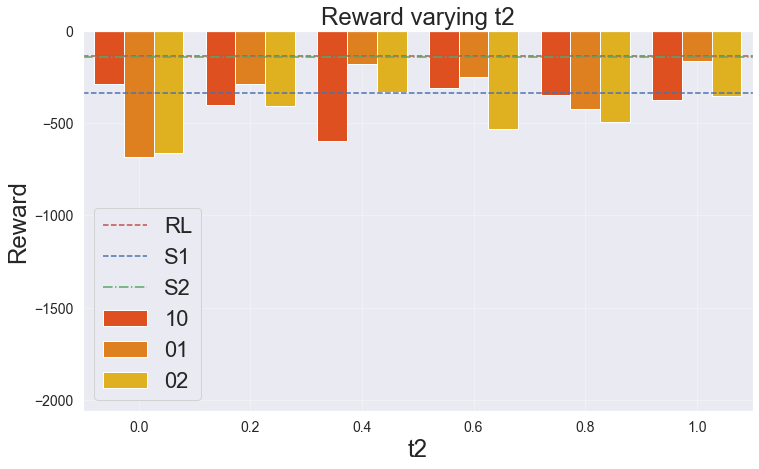

[8.651169023820456, 9.556737518473017, 12.058541155488301, 10.917812478919263, 34.99791417781053]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  15.5167 	 Rew:  -387.4869 	 Viol.: 6.999999999999998
MCA 01	 -> Length:  38.9500 	 Rew:  -331.0437 	 Viol.: 3.683333333333333
MCA 55	 -> Length:  19.1833 	 Rew:  -463.4124 	 Viol.: 8.2
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


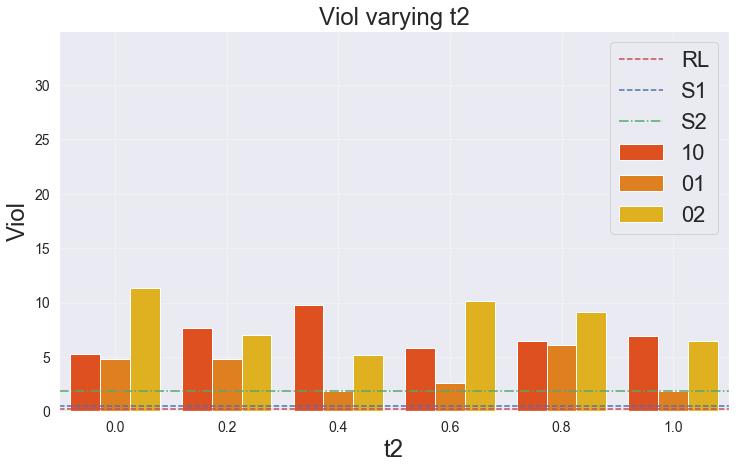

[1.020723234928426, 1.039667900949046, 1.0067693680959025, 0.973504865928162, 1.1214340261963607]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  15.5167 	 Rew:  -387.4869 	 Viol.: 6.999999999999998
MCA 01	 -> Length:  38.9500 	 Rew:  -331.0437 	 Viol.: 3.683333333333333
MCA 55	 -> Length:  19.1833 	 Rew:  -463.4124 	 Viol.: 8.2
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


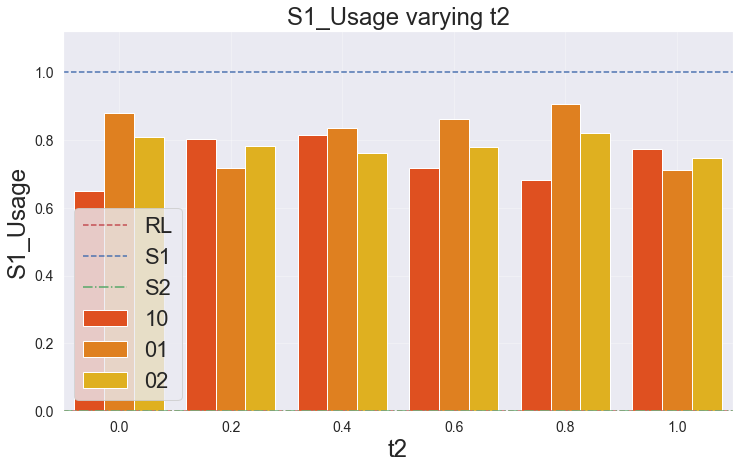

In [10]:
label_x = 't2'
label='Length'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df2,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='Reward'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df2,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='Viol'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df2,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='S1_Usage'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df2,x=label_x,y=label, min_label=min_label, max_label=max_label)

[42.621926688511145, 53.3776329737806, 38.167933684908, 41.32305575228073, 96.30558993810897]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  13.9833 	 Rew:  -403.5359 	 Viol.: 7.516666666666667
MCA 01	 -> Length:  20.3000 	 Rew:  -196.4678 	 Viol.: 2.55
MCA 55	 -> Length:  21.8833 	 Rew:  -589.9725 	 Viol.: 10.666666666666663
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


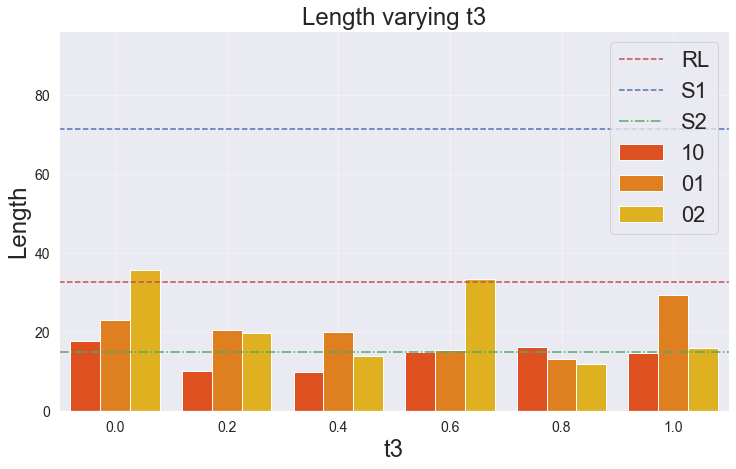

[-493.7022596866881, -580.0741490373201, -669.3357197192875, -613.62720506348, -2061.994014564892]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  13.9833 	 Rew:  -403.5359 	 Viol.: 7.516666666666667
MCA 01	 -> Length:  20.3000 	 Rew:  -196.4678 	 Viol.: 2.55
MCA 55	 -> Length:  21.8833 	 Rew:  -589.9725 	 Viol.: 10.666666666666663
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


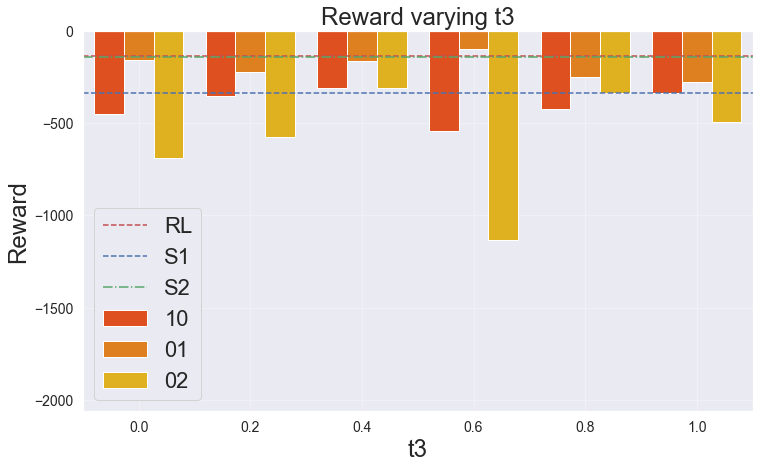

[8.651169023820456, 9.556737518473017, 12.058541155488301, 10.917812478919263, 34.99791417781053]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  13.9833 	 Rew:  -403.5359 	 Viol.: 7.516666666666667
MCA 01	 -> Length:  20.3000 	 Rew:  -196.4678 	 Viol.: 2.55
MCA 55	 -> Length:  21.8833 	 Rew:  -589.9725 	 Viol.: 10.666666666666663
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


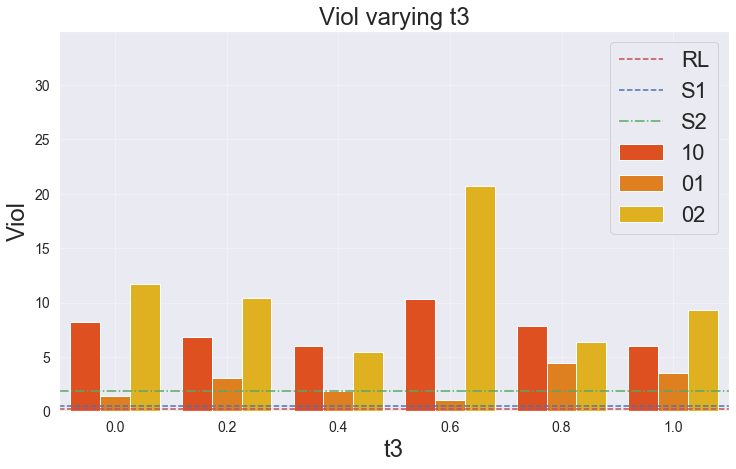

[1.020723234928426, 1.039667900949046, 1.0067693680959025, 0.973504865928162, 1.1214340261963607]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  13.9833 	 Rew:  -403.5359 	 Viol.: 7.516666666666667
MCA 01	 -> Length:  20.3000 	 Rew:  -196.4678 	 Viol.: 2.55
MCA 55	 -> Length:  21.8833 	 Rew:  -589.9725 	 Viol.: 10.666666666666663
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


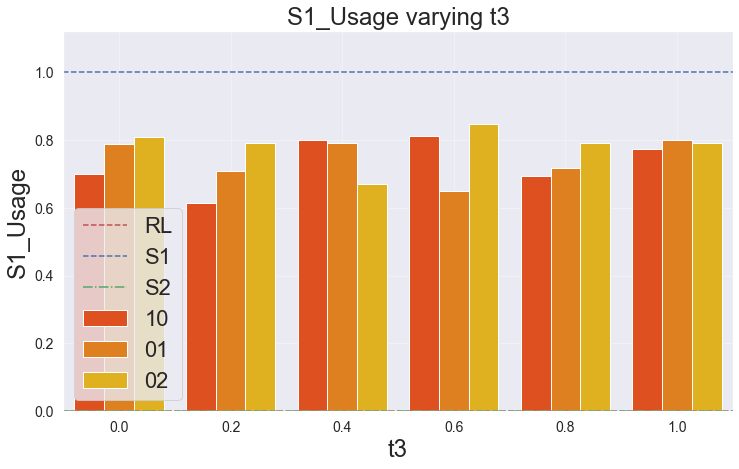

In [11]:
label_x = 't3'
label='Length'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df3,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='Reward'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df3,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='Viol'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df3,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='S1_Usage'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df3,x=label_x,y=label, min_label=min_label, max_label=max_label)

[42.621926688511145, 53.3776329737806, 38.167933684908, 41.32305575228073, 96.30558993810897]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  22.1000 	 Rew:  -539.9041 	 Viol.: 9.583333333333332
MCA 01	 -> Length:  26.9667 	 Rew:  -283.1258 	 Viol.: 3.783333333333333
MCA 55	 -> Length:  19.0000 	 Rew:  -439.3707 	 Viol.: 7.816666666666666
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


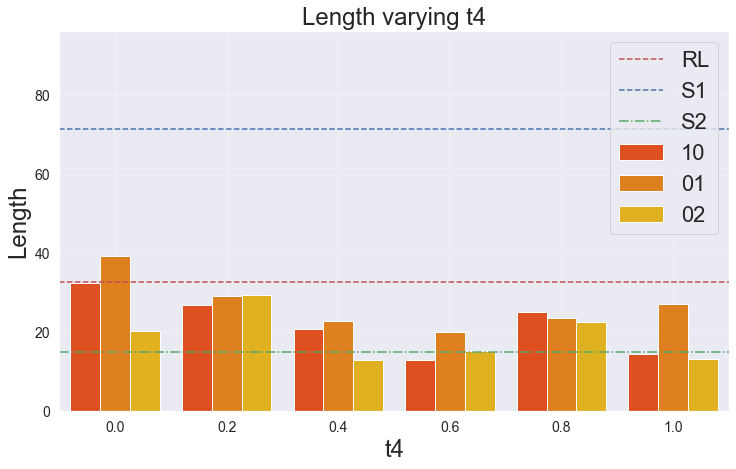

[-493.7022596866881, -580.0741490373201, -669.3357197192875, -613.62720506348, -2061.994014564892]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  22.1000 	 Rew:  -539.9041 	 Viol.: 9.583333333333332
MCA 01	 -> Length:  26.9667 	 Rew:  -283.1258 	 Viol.: 3.783333333333333
MCA 55	 -> Length:  19.0000 	 Rew:  -439.3707 	 Viol.: 7.816666666666666
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


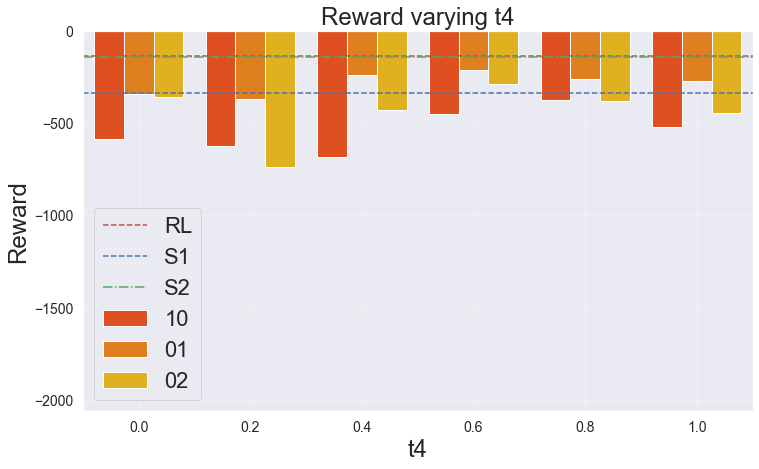

[8.651169023820456, 9.556737518473017, 12.058541155488301, 10.917812478919263, 34.99791417781053]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  22.1000 	 Rew:  -539.9041 	 Viol.: 9.583333333333332
MCA 01	 -> Length:  26.9667 	 Rew:  -283.1258 	 Viol.: 3.783333333333333
MCA 55	 -> Length:  19.0000 	 Rew:  -439.3707 	 Viol.: 7.816666666666666
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


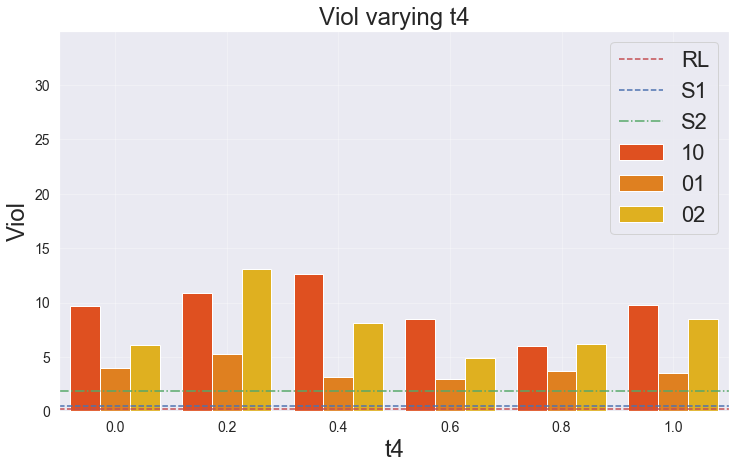

[1.020723234928426, 1.039667900949046, 1.0067693680959025, 0.973504865928162, 1.1214340261963607]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  22.1000 	 Rew:  -539.9041 	 Viol.: 9.583333333333332
MCA 01	 -> Length:  26.9667 	 Rew:  -283.1258 	 Viol.: 3.783333333333333
MCA 55	 -> Length:  19.0000 	 Rew:  -439.3707 	 Viol.: 7.816666666666666
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


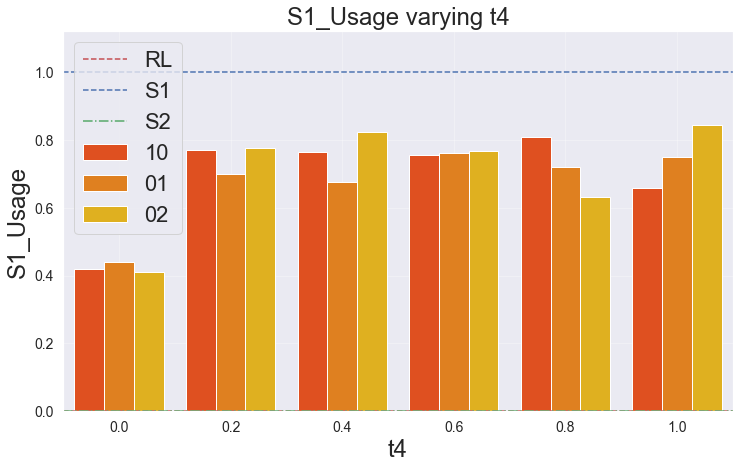

[0.7068808521475126, 0.6641100731365412, 0.6666192232966393, 0.6560506334609797, 0.6644711626518366]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  22.1000 	 Rew:  -539.9041 	 Viol.: 9.583333333333332
MCA 01	 -> Length:  26.9667 	 Rew:  -283.1258 	 Viol.: 3.783333333333333
MCA 55	 -> Length:  19.0000 	 Rew:  -439.3707 	 Viol.: 7.816666666666666
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


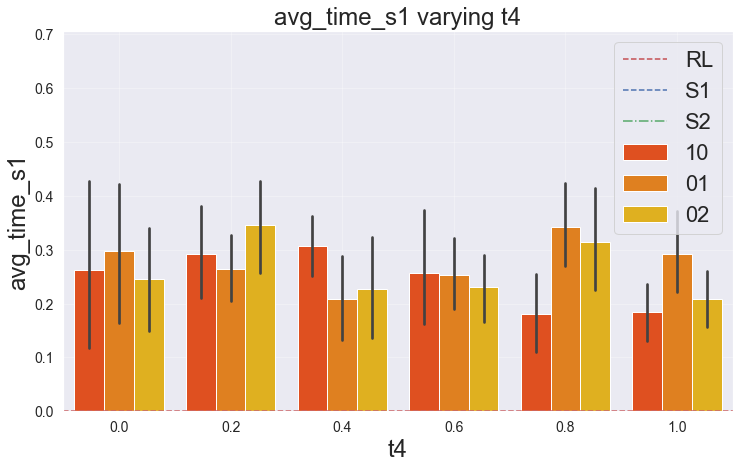

In [12]:
label_x = 't4'
label='Length'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df4,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='Reward'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df4,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='Viol'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df4,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='S1_Usage'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df4,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='avg_time_s1'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df4,x=label_x,y=label, min_label=min_label, max_label=max_label)

[42.621926688511145, 53.3776329737806, 38.167933684908, 41.32305575228073, 96.30558993810897]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  31.3500 	 Rew:  -800.3828 	 Viol.: 14.15
MCA 01	 -> Length:  61.3167 	 Rew: -1135.4870 	 Viol.: 18.400000000000002
MCA 55	 -> Length:  31.6667 	 Rew:  -803.7153 	 Viol.: 14.266666666666671
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


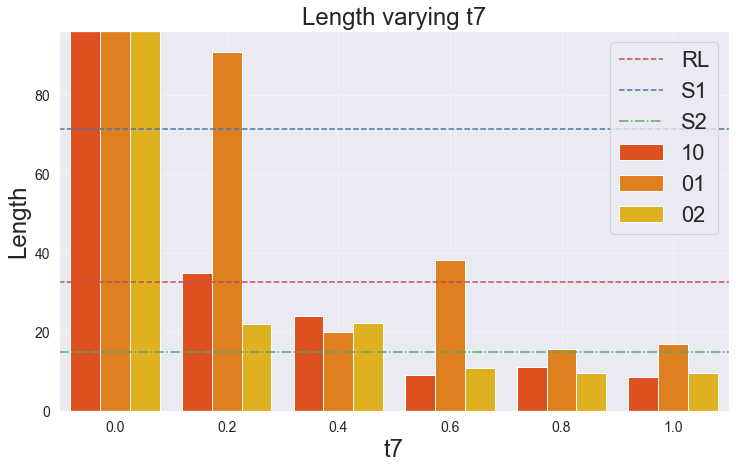

[-493.7022596866881, -580.0741490373201, -669.3357197192875, -613.62720506348, -2061.994014564892]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  31.3500 	 Rew:  -800.3828 	 Viol.: 14.15
MCA 01	 -> Length:  61.3167 	 Rew: -1135.4870 	 Viol.: 18.400000000000002
MCA 55	 -> Length:  31.6667 	 Rew:  -803.7153 	 Viol.: 14.266666666666671
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


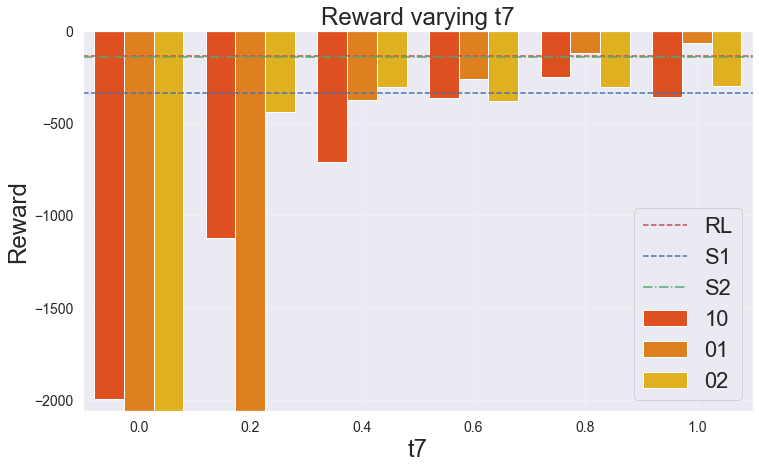

[8.651169023820456, 9.556737518473017, 12.058541155488301, 10.917812478919263, 34.99791417781053]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  31.3500 	 Rew:  -800.3828 	 Viol.: 14.15
MCA 01	 -> Length:  61.3167 	 Rew: -1135.4870 	 Viol.: 18.400000000000002
MCA 55	 -> Length:  31.6667 	 Rew:  -803.7153 	 Viol.: 14.266666666666671
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


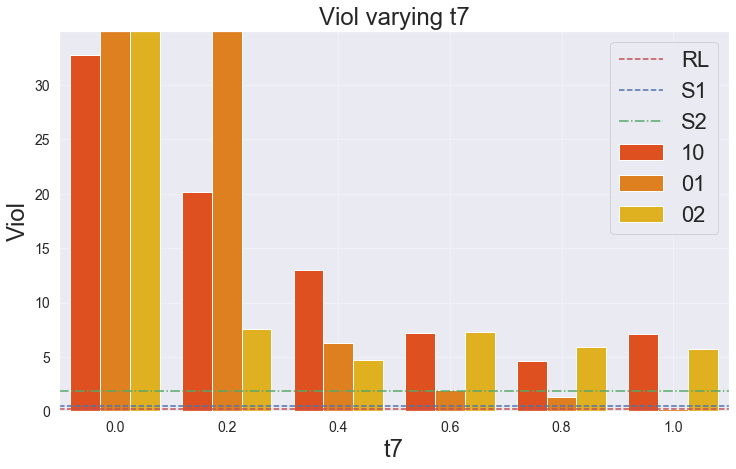

[1.020723234928426, 1.039667900949046, 1.0067693680959025, 0.973504865928162, 1.1214340261963607]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  31.3500 	 Rew:  -800.3828 	 Viol.: 14.15
MCA 01	 -> Length:  61.3167 	 Rew: -1135.4870 	 Viol.: 18.400000000000002
MCA 55	 -> Length:  31.6667 	 Rew:  -803.7153 	 Viol.: 14.266666666666671
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


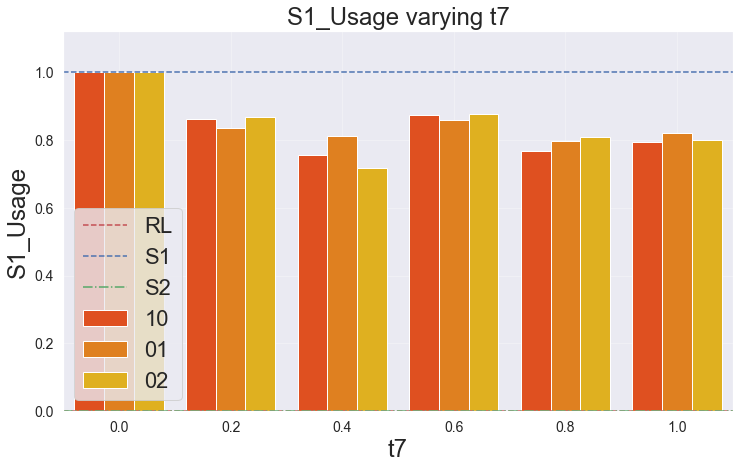

[0.7068808521475126, 0.6641100731365412, 0.6666192232966393, 0.6560506334609797, 0.6644711626518366]
RL	 -> Length:  32.7700 	 Rew:  -134.5603 	 Viol.: 0.175
MCA 10	 -> Length:  31.3500 	 Rew:  -800.3828 	 Viol.: 14.15
MCA 01	 -> Length:  61.3167 	 Rew: -1135.4870 	 Viol.: 18.400000000000002
MCA 55	 -> Length:  31.6667 	 Rew:  -803.7153 	 Viol.: 14.266666666666671
Only S1	 -> Length:  71.5000 	 Rew:  -339.4390 	 Viol.: 0.5
Only S2	 -> Length:  15.1000 	 Rew:  -142.6284 	 Viol.: 1.8999999999999997


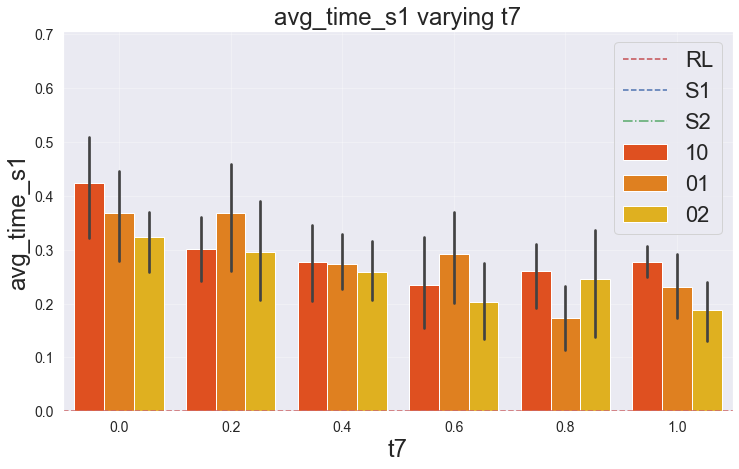

In [13]:
label_x = 't7'
label='Length'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df7,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='Reward'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df7,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='Viol'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df7,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='S1_Usage'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df7,x=label_x,y=label, min_label=min_label, max_label=max_label)

label='avg_time_s1'
min_label, max_label = min_max(label, df, df2, df3, df4, df7)
plot_results(df7,x=label_x,y=label, min_label=min_label, max_label=max_label)

In [14]:
df.loc[(df['type']=='02') & (df['t1']==200)]
#mca_s2.__dict__
#df

,traj_n,time_s1,time_s2,avg_time_s1,avg_time_s2,usage_s1,usage_s2,type,Length,Reward,Viol,S1_Usage,t1,t2,t3,t4,t6,t7
0,0,1,207,0.125000,25.875000,0.500000,0.500000,02,12.1,-305.594113,5.7,0.701504,200,0.5,0.5,0.5,1,0.5
1,1,2,162,0.250000,20.250000,0.500000,0.500000,02,12.1,-305.594113,5.7,0.701504,200,0.5,0.5,0.5,1,0.5
2,2,2,102,0.166667,20.400000,0.705882,0.294118,02,12.1,-305.594113,5.7,0.701504,200,0.5,0.5,0.5,1,0.5
3,3,2,141,0.333333,20.142857,0.461538,0.538462,02,12.1,-305.594113,5.7,0.701504,200,0.5,0.5,0.5,1,0.5
4,4,1,101,0.142857,20.200000,0.583333,0.416667,02,12.1,-305.594113,5.7,0.701504,200,0.5,0.5,0.5,1,0.5
5,5,5,82,0.416667,20.500000,0.750000,0.250000,02,12.1,-305.594113,5.7,0.701504,200,0.5,0.5,0.5,1,0.5
6,6,2,0,0.285714,NaN,1.000000,0.000000,02,12.1,-305.594113,5.7,0.701504,200,0.5,0.5,0.5,1,0.5
7,7,3,43,0.375000,21.500000,0.800000,0.200000,02,12.1,-305.594113,5.7,0.701504,200,0.5,0.5,0.5,1,0.5
8,8,1,22,0.166667,22.000000,0.857143,0.142857,02,12.1,-305.594113,5.7,0.701504,200,0.5,0.5,0.5,1,0.5
9,9,2,22,0.333333,22.000000,0.857143,0.142857,02,12.1,-305.594113,5.7,0.701504,200,0.5,0.5,0.5,1,0.5


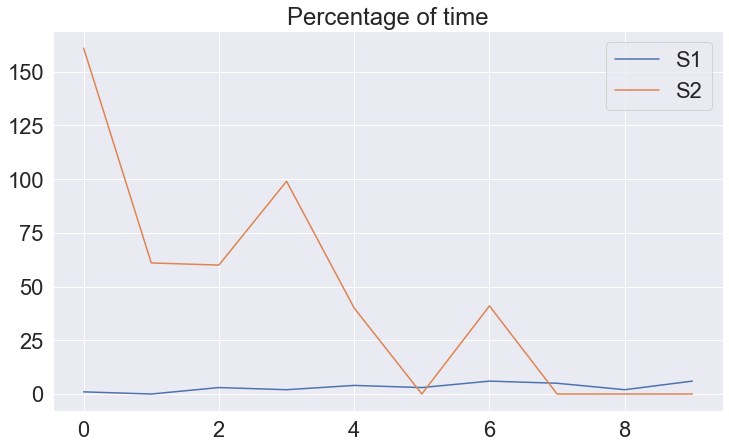

In [15]:
df.loc[(df['type']=='02') & (df['t1']==200)]



plt.figure(figsize=(12, 7))
plt.plot(df.loc[(df['type']=='10') & (df['t1']==200)]['time_s1'].values, label="S1")
plt.plot(df.loc[(df['type']=='10') & (df['t1']==200)]['time_s2'].values, label="S2")
plt.title("Percentage of time")
plt.legend()
plt.show()